In [1]:
from PIL import Image
import torch
import pickle
torch.set_printoptions(sci_mode=False)
from torchvision import transforms
from glob import glob
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Dino")
from dino_utils import dino_processor, setup_dino_model
os.chdir(current_wd)

Using mps as device
Using mps as device
Using mps as device


/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def plot_from_latent(latent):
    gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
    return tensor2im(gen.squeeze(0))

## 1. Setup Models

### 1.1. Dino Model

In [6]:
device = torch.device('cpu')
dino_model = setup_dino_model(device)

# Freeze the model
for param in dino_model.parameters():
    param.requires_grad = False

### 1.2. Generator Model
- Either hyperstyle or PTI

In [7]:
os.chdir(f"{ROOT_PATH}/2_Inversion/PTI/")
from pti_utils import load_pti
os.chdir(current_wd)


sku = "02R21C014-Q11"
G_PTI, latent = load_pti(sku)

# Freeze and set to eval
G_PTI.eval()
for param in G_PTI.parameters():
    param.requires_grad = False

# Send to CPU
G_PTI = G_PTI.to(device)
latent = latent.to(device)

### 1.3. Classifier Model

In [8]:
classifier_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/category_pti_embeddings.pt"
model = torch.load(classifier_path, map_location = 'cpu').to(device)

softmax = torch.nn.Softmax(dim=1)

# Freeze and set to eval
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [9]:
# Load id2label dict
id2label = pickle.load(open(f"{ROOT_PATH}/4_Assessor/Dino/id2label_dicts/category_id2label.pkl", "rb"))
id2label

{0: 'Day dress',
 1: 'Jumper dress',
 2: 'Jersey dress',
 3: 'Cocktail dress / Party dress',
 4: 'Maxi dress',
 5: 'Occasion wear',
 6: 'Shift dress',
 7: 'Denim dress'}

### 1.4. Discriminator Mode

In [10]:
os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
# Load model architecture
experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
model_name = "network-snapshot-001200.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    D = architecture['D']
os.chdir(current_wd)

In [11]:
# Freeze and set to eval
D.eval()
for param in D.parameters():
    param.requires_grad = False

# Send to CPU
D = D.to(torch.device('mps'))

## 2. Test Functioning of the components

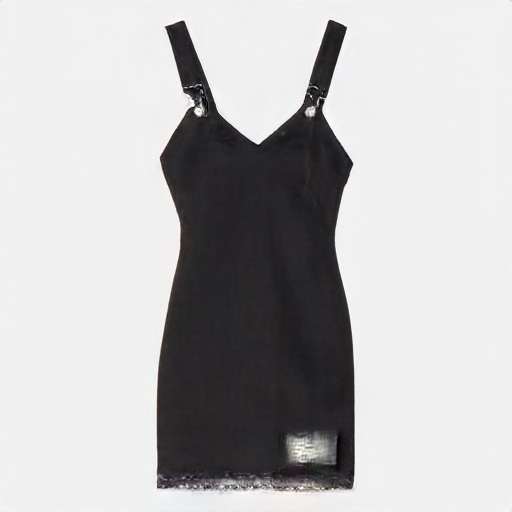

In [12]:
gen = G_PTI.synthesis(latent, noise_mode='const', force_fp32=True)
tensor2im(gen.squeeze(0))

In [13]:
dino_input = dino_processor(gen)
dino_output = dino_model(dino_input)
classifier_output = model(dino_output)
scores = softmax(classifier_output)

# Merge scores with id2label
scores_dict = {id2label[key]: value for key, value in enumerate(scores.squeeze().tolist())}
scores_dict

{'Day dress': 0.353958398103714,
 'Jumper dress': 0.2436087727546692,
 'Jersey dress': 0.0045633395202457905,
 'Cocktail dress / Party dress': 6.218033377081156e-07,
 'Maxi dress': 0.007905784994363785,
 'Occasion wear': 9.409209451405331e-05,
 'Shift dress': 0.3895097076892853,
 'Denim dress': 0.0003593027649912983}

### Test some Manipulations

In [14]:
latent_orig = latent.clone()
latent_orig.requires_grad = True

In [15]:
target_class = 0
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam([latent_orig], lr=1e-2)

  0%|          | 0/30 [00:00<?, ?it/s]

Target score: 0.353958398103714 | Loss: 0.4173697829246521


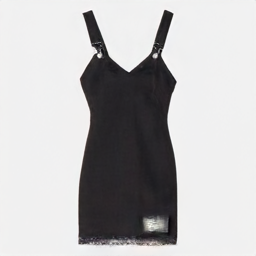

Target score: 0.22137656807899475 | Loss: 0.606254518032074
Target score: 0.5770339369773865 | Loss: 0.17890028655529022
Target score: 0.7318150997161865 | Loss: 0.0719231441617012
Target score: 0.678825318813324 | Loss: 0.10315317660570145
Target score: 0.8585392236709595 | Loss: 0.02001115120947361
Target score: 0.9293431639671326 | Loss: 0.004992388654500246
Target score: 0.926771342754364 | Loss: 0.0053624361753463745
Target score: 0.9189481139183044 | Loss: 0.006569408345967531
Target score: 0.9085348844528198 | Loss: 0.008365867659449577
Target score: 0.8966243863105774 | Loss: 0.01068651769310236


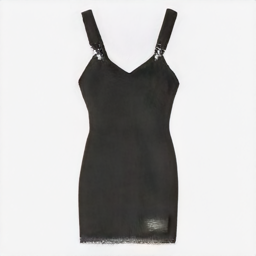

Target score: 0.9047344326972961 | Loss: 0.009075528010725975
Target score: 0.927662193775177 | Loss: 0.005232758354395628
Target score: 0.9403482675552368 | Loss: 0.0035583290737122297
Target score: 0.9525349736213684 | Loss: 0.0022529286798089743
Target score: 0.9626848697662354 | Loss: 0.00139241898432374
Target score: 0.9664736986160278 | Loss: 0.0011240128660574555
Target score: 0.9668869972229004 | Loss: 0.0010964709799736738
Target score: 0.9657557010650635 | Loss: 0.001172672025859356
Target score: 0.9668934345245361 | Loss: 0.0010960446670651436
Target score: 0.9715389013290405 | Loss: 0.0008100341656245291


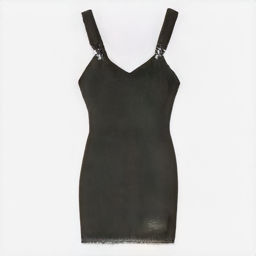

Target score: 0.9758657217025757 | Loss: 0.0005824633990414441
Target score: 0.9795292019844055 | Loss: 0.00041905356920324266
Target score: 0.9818338751792908 | Loss: 0.0003300081007182598
Target score: 0.9826104044914246 | Loss: 0.00030239802435971797
Target score: 0.9830501675605774 | Loss: 0.0002872968325391412
Target score: 0.9834623336791992 | Loss: 0.00027349439915269613
Target score: 0.9837486743927002 | Loss: 0.0002641055907588452
Target score: 0.9840108752250671 | Loss: 0.0002556521212682128
Target score: 0.9841981530189514 | Loss: 0.00024969837977550924


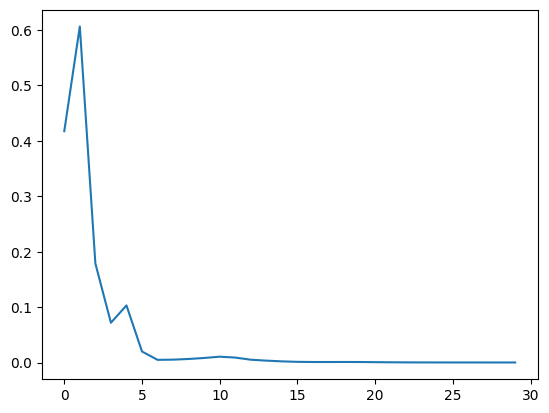

In [16]:
num_steps = 30

losses = []
for i in tqdm(range(num_steps), leave=False):
    optimizer.zero_grad()
    # Forward pass
    gen = G_PTI.synthesis(latent_orig, noise_mode='const', force_fp32=True)
    dino_input = dino_processor(gen)
    dino_output = dino_model(dino_input)
    classifier_output = model(dino_output)
    scores = softmax(classifier_output)
    target_score = scores[0, target_class]

    # Loss and backward pass
    loss = loss_fn(target_score, torch.tensor(1.0))
    loss.backward()
    print(f"Step: {i} Target score: {target_score.item()} | Loss: {loss.item()}")
    optimizer.step()
    losses.append(loss.item())

    if i % 10 == 0:
        display(tensor2im(gen.squeeze(0)).resize((256, 256)))

plt.plot(losses)

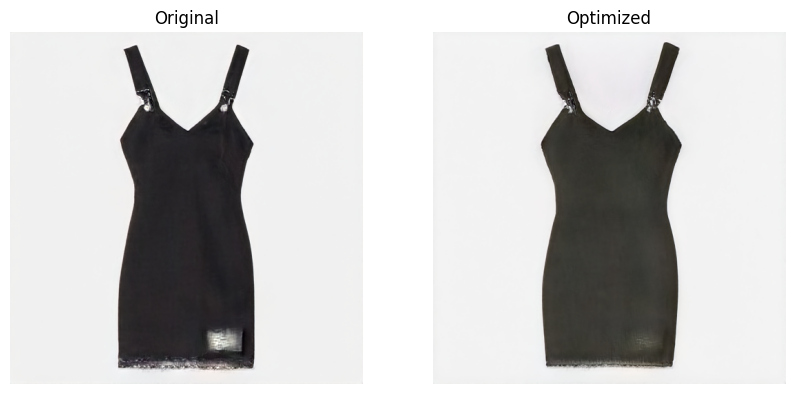

In [17]:
# Plot original
orig = plot_from_latent(latent)
# Plot optimized
optimized = plot_from_latent(latent_orig)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(orig)
ax[0].set_title("Original")
ax[0].axis('off')
ax[1].imshow(optimized)
ax[1].set_title("Optimized")
ax[1].axis('off')
plt.show()

In [18]:
torch.nn.functional.cosine_similarity(latent.flatten(), latent_orig.flatten(), dim=0)

tensor(0.9982, grad_fn=<SumBackward1>)

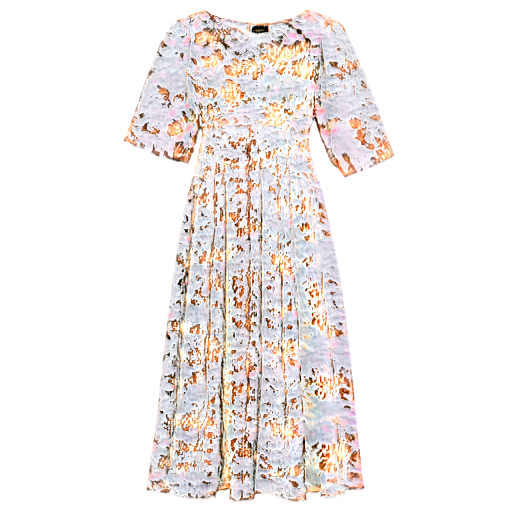

In [52]:
z = torch.randn(1, 512, device=device)

w = G_PTI.mapping(z, None)
img = G_PTI.synthesis(w, force_fp32=True, noise_mode='const')
tensor2im(img.squeeze(0))